<a href="https://colab.research.google.com/github/ShesterG/Twitter-Sentiment-Analysis/blob/master/notebooks/svm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM with Smote Model for Twitter Sentiment Analysis

This model will use SVM with tf/idf to classify the tweets.

It will reduce the dimensionality of the feature set by adjusting the minimum document frequency of words, in an attempt to get better results.

It will use SMOTE to synthesize some data to balance the classes.

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Imports and Constants

In [2]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelBinarizer
#import evaluation_functions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import ast


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import make_scorer



/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
DATA_FILE_PATH = '/content/drive/MyDrive/NLPGh/'
CLEAN_DATA_FILE_NAME = 'Book10Clean.csv'
TOKENIZED_DATA_FILE_NAME = 'Book10Tokenized.csv'
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42

# Load Data

In [4]:
df = pd.read_csv(DATA_FILE_PATH + TOKENIZED_DATA_FILE_NAME)

In [5]:
df.head()

,Unnamed: 0,tweet,location_x,pretweet,candidate,LRPredScore,LRConfi,Sentiment,Unnamed: 8,tokens
0,2,"@NAkufoAddo H. E Nana please follow up on this FAKE NEWS, LIES and sue BBC for peddling false information. Hold alÃ¢â¬Â¦ https://t.co/SdwnMsxeUV",NaN,nana pleas follow thi fake new lie and sue bbc for peddl fals inform hold al,Nana,-3.0,1.0,0,NaN,"['nana', 'pleas', 'follow', 'thi', 'fake', 'new', 'lie', 'and', 'sue', 'bbc', 'for', 'peddl', 'fals', 'inform', 'hold', 'al']"
1,6,"@ChipsJhay @TruthFreema @AOuattara_PRCI @NAkufoAddo No, you haven't. He's using his freedom of speech as it is. He's covered.","Afamase Akotom, Ghana",no you havent he use hi freedom speech is he cover,Nana,NaN,NaN,0,NaN,"['no', 'you', 'havent', 'he', 'use', 'hi', 'freedom', 'speech', 'is', 'he', 'cover']"
2,7,@IssahGerard @HEgyiri @NAkufoAddo Please who is this and how is he your in law??,NaN,pleas who thi and how your law,Nana,-1.0,1.0,0,NaN,"['pleas', 'who', 'thi', 'and', 'how', 'your', 'law']"
3,17,@Kwame34580189 @bukolasaraki @NAkufoAddo Whatever.... Thought you had something there....,Nigeria,whatev thought you had someth there,Nana,NaN,NaN,0,NaN,"['whatev', 'thought', 'you', 'had', 'someth', 'there']"
4,18,@NAkufoAddo Remember that the good people of Gh have spoken therefore Soo be it,NaN,rememb that the good peopl have spoken therefor soo,Nana,1.0,1.0,0,NaN,"['rememb', 'that', 'the', 'good', 'peopl', 'have', 'spoken', 'therefor', 'soo']"


In [6]:
df = df[df.Sentiment != 0]

In [7]:
# convert list of strings represented as a string to a list of strings
df.tokens = df.tokens.map(ast.literal_eval)

In [8]:
data = df[['tokens', 'Sentiment']]

In [9]:
data.Sentiment.value_counts()

 1    1000
-1    1000
Name: Sentiment, dtype: int64

In [10]:
data.head()

,tokens,Sentiment
1000,"[they, dont, know, anyth, about, peac]",-1
1001,"[good, may, god, bless, protect, you]",1
1002,"[presid, receiv, the, grace, god, almighti, what, ha, ordain, you, for, jesu, mighti, name]",1
1003,"[gad, cant, believ, itu, are, congratul, dem, npp, parti, are, corrupt]",-1
1004,"[pleas, may, god, continu, strengthen, you, more, pleas]",1


# Split Data

In [11]:
"""
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], 
                                                    data['Sentiment'],
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = data['Sentiment'])
"""  

X = data['tokens']
y = data['Sentiment']

In [12]:
#X_train.shape

In [13]:
#X_test.shape

# Encode Labels

In [14]:
le = LabelEncoder()

In [15]:
#y_train_enc = le.fit_transform(y_train)

In [16]:
#y_test_enc = le.transform(y_test)

In [17]:
y_enc = le.fit_transform(y)

# Evaluate Adjustments to Minimum Document Frequency

In [18]:
def passthrough(doc):
    """passthrough function for use in the pipeline because the text is already tokenized"""
    return doc

In [19]:
def train_and_eval_model(min_df):
    """
    Train and Evaluate and Bag of Words Representation with a SVM
    classifier with a specified minimum document frequency.
    """
    
    pipeline = Pipeline([('bow',CountVectorizer(min_df=min_df, 
                                                preprocessor=passthrough, 
                                                tokenizer=passthrough)),
                         ('tfidf', TfidfTransformer()),
                         ('smote', SMOTE(random_state=RANDOM_STATE, 
                                         n_jobs=-1)),
                         ('SVM', SVC(kernel = 'linear', probability = True, random_state = RANDOM_STATE))
                         ])
    

    #scores = cross_validation.cross_val_score(Pipeline, X_train,y_train_enc, cv=10)
    #pipeline.score
    #scoring = ['accuracy','f1','precision','recall']
    
    scoring = {'accuracy' : make_scorer(accuracy_score),
               'f1_score' : make_scorer(f1_score, average = 'micro'), 
               'precision' : make_scorer(precision_score, average = 'micro'),
               'recall' : make_scorer(recall_score, average = 'micro') 
              }
    
    scores = cross_validate(pipeline, X, y_enc, cv=10, scoring=scoring)
    sorted(scores.keys())

    y_pred = cross_val_predict(pipeline, X, y_enc, cv=10)

    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    
    conf_matrix = confusion_matrix(y_true=y_enc, y_pred=y_pred)

    classi_report = classification_report(y_true=y_enc, y_pred=y_pred, digits=4, target_names=['Negative','Postive'])
    print(classi_report)

    """
    #y_pred = cross_val_predict(Pipeline, X, Y, cv=10)
    
    
    #y_pred = pipeline.predict(X_test)



    #conf_matrix = confusion_matrix(y_true=y_test_enc, y_pred=y_pred)
    #confusion_matrix(y_true=y_train_enc, y_pred=pipeline.predict(X_train),labels='Training')

    
    #classi_report = classification_report(y_true=y_test_enc, y_pred=y_pred, target_names=['Negative', 'Postive'])
    #print(classi_report)
    ['fit_time', 'score_time', 'test_prec_macro', 'test_rec_macro',
 'train_prec_macro', 'train_rec_macro']

    
    #train_accuracy = accuracy_score(y_train_enc, pipeline.predict(X_train))
    
    test_accuracy = accuracy_score(y_test_enc, pipeline.predict(X_test))
    
    ave_macro_recall = recall_score(y_test_enc, pipeline.predict(X_test), average='macro')
    recall_scores = recall_score(y_test_enc, pipeline.predict(X_test), average=None)
    
    test_results = np.append(np.array([min_df, train_accuracy, test_accuracy, ave_macro_recall]),
                             recall_scores, score_mean)
    """
    a = scores['test_accuracy'].mean()
    f = scores['test_f1_score'].mean()
    p = scores['test_precision'].mean()
    r = scores['test_recall'].mean()
    test_results = np.append(np.array([min_df, a, f, p]),r)
    
    
   
    return test_results, conf_matrix, y_pred 
    

In [20]:
metrics_summary = []

for min_df in range(1,11):
    test_scores, conf_matrix, y_pred = train_and_eval_model(min_df)
    metrics_summary.append(test_scores)

MINIMUM DOCUMENT FREQUENCY = 1

              precision    recall  f1-score   support

    Negative     0.8380    0.8690    0.8532      1000
     Postive     0.8640    0.8320    0.8477      1000

    accuracy                         0.8505      2000
   macro avg     0.8510    0.8505    0.8504      2000
weighted avg     0.8510    0.8505    0.8504      2000

MINIMUM DOCUMENT FREQUENCY = 2

              precision    recall  f1-score   support

    Negative     0.8303    0.8760    0.8526      1000
     Postive     0.8688    0.8210    0.8442      1000

    accuracy                         0.8485      2000
   macro avg     0.8496    0.8485    0.8484      2000
weighted avg     0.8496    0.8485    0.8484      2000

MINIMUM DOCUMENT FREQUENCY = 3

              precision    recall  f1-score   support

    Negative     0.8364    0.8690    0.8524      1000
     Postive     0.8637    0.8300    0.8465      1000

    accuracy                         0.8495      2000
   macro avg     0.8500    0.849

In [21]:
metrics_summary_df = pd.DataFrame(metrics_summary, 
                                  columns=['min doc freq',
                                           'accuracy',
                                           'f1_score',
                                           'precision',
                                          'recall'
                                          ])

metrics_summary_df

,min doc freq,accuracy,f1_score,precision,recall
0,1.0,0.8505,0.8505,0.8505,0.8505
1,2.0,0.8485,0.8485,0.8485,0.8485
2,3.0,0.8495,0.8495,0.8495,0.8495
3,4.0,0.8475,0.8475,0.8475,0.8475
4,5.0,0.8430,0.8430,0.8430,0.8430
5,6.0,0.8375,0.8375,0.8375,0.8375
6,7.0,0.8405,0.8405,0.8405,0.8405
7,8.0,0.8460,0.8460,0.8460,0.8460
8,9.0,0.8405,0.8405,0.8405,0.8405
9,10.0,0.8375,0.8375,0.8375,0.8375


MINIMUM DOCUMENT FREQUENCY = 1

              precision    recall  f1-score   support

    Negative     0.8380    0.8690    0.8532      1000
     Postive     0.8640    0.8320    0.8477      1000

    accuracy                         0.8505      2000
   macro avg     0.8510    0.8505    0.8504      2000
weighted avg     0.8510    0.8505    0.8504      2000



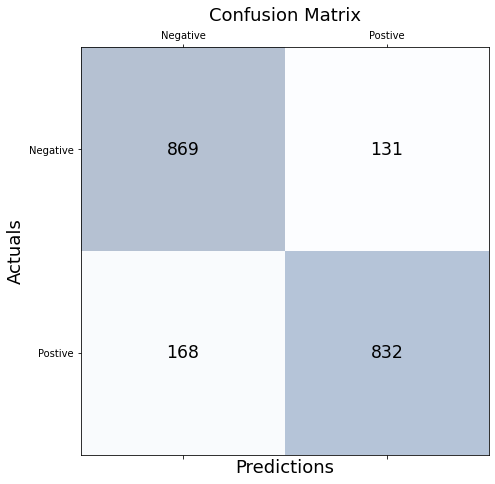

In [22]:
_,conf_matrix, y_pred = train_and_eval_model(min_df=1)
labels = ['Negative', 'Postive']

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [23]:
y_enc

array([0, 1, 1, ..., 1, 1, 1])

In [24]:
df2 = pd.DataFrame()

df2['X_test'] =  X
df2['y_test_enc'] =  y_enc
df2['y_pred'] =  y_pred

#df2[df2["y_test_enc"]==-1 & df2["y_pred"]==1].item()

In [25]:
df2[np.logical_and.reduce([df2['y_test_enc'] == 1, df2['y_pred'] == 0])]

,X_test,y_test_enc,y_pred
1006,"[ghana, name, winner, the, presidentialelection, report]",1,0
1011,"[said, better]",1,0
1012,"[you, challeng, court, not, press, confer, januari, moov]",1,0
1023,"[ghana, elect, the, presidentelect]",1,0
1033,"[you, and, who, those, who, know, what, they, are, about, elect, him]",1,0
...,...,...,...
2977,"[under, manasseh, and, ana, aremeyaw, ana, oper, freeli, without, oppress, and, fear, for, their, live, today]",1,0
2981,"[aww, sir, the, same, way, thing, here, ooo, they, made, look, foolish, but, they, lie, bad]",1,0
2983,"[votejm, that, togeth, can, build, ghana, that, secur, prosper, and, give, everyon, fair, chanc]",1,0
2984,"[that, their, regular, trademark, lie, and, corrupt, vote, dec, kicknanaout, and]",1,0


In [26]:
df.loc[852,'tweet']

KeyError: ignored

In [ ]:
df2[df2["y_test_enc"]==-1 & df2["y_pred"]==1].item()

# Summary

The addition of SMOTE oversampling generally improved the SVM as negative classes have better scores. 

In [ ]:
easy.py